In [0]:
# PySpark Functions (organizados por categoria)
from pyspark.sql.functions import (
    col, when, lit, isnull, round,
    mean, stddev, min, max, count,
    to_timestamp, to_date, date_format,
    year, month, dayofmonth, hour,
    weekofyear, dayofweek, quarter,
    current_timestamp
)

# PySpark Types
from pyspark.sql.types import *

# PySpark Exceptions
from pyspark.sql.utils import AnalysisException

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades
from IPython.display import display
import numpy as np
import pandas as pd

Para atingir os objetivos propostos, utilizamos a base de dados de acidentes de trânsito com vítimas, disponível em [link]. A seguir, iniciamos a leitura do arquivo original e aplicamos transformações para padronizar os dado

In [0]:
# 1. Carregar os dados ORIGINAIS (não da tabela, mas do arquivo fonte)

df = spark.read.csv(
    "/FileStore/tables/si_bol_2021.csv",
    header=True,
    sep=";",
    inferSchema=True
    ,encoding="ISO-8859-1"
)
df.show(5)

+------------------+------------------+----------------+--------------+--------------------+----------+---------------+--------------+---------------+-------------+---------------+---------------+-----------------+---------------------+-------------+-------------+---------------+---------------------+----------+--------------+--------------------+-----------------+---------------------+
|    NUMERO_BOLETIM| DATA HORA_BOLETIM|   DATA_INCLUSAO| TIPO_ACIDENTE|  DESC_TIPO_ACIDENTE| COD_TEMPO|     DESC_TEMPO| COD_PAVIMENTO|      PAVIMENTO| COD_REGIONAL|  DESC_REGIONAL| ORIGEM_BOLETIM| LOCAL_SINALIZADO| VELOCIDADE_PERMITIDA| COORDENADA_X| COORDENADA_Y| HORA_INFORMADA| INDICADOR_FATALIDADE| VALOR_UPS| DESCRIÇÃO_UPS| DATA_ALTERACAO_SMSA| VALOR_UPS_ANTIGA| DESCRIÇÃO_UPS_ANTIGA|
+------------------+------------------+----------------+--------------+--------------------+----------+---------------+--------------+---------------+-------------+---------------+---------------+-----------------+------

In [0]:
# 2. Transformações 
df_clean = (df
    # Renomear colunas
    .select(
        col(" NUMERO_BOLETIM").alias("numero_boletim"),
        col(" DATA HORA_BOLETIM").alias("data_hora_boletim_raw"),
        col(" DATA_INCLUSAO").alias("data_inclusao_raw"),
        col(" TIPO_ACIDENTE").alias("tipo_acidente"),
        col(" DESC_TIPO_ACIDENTE").alias("descricao_tipo_acidente"),
        col(" COD_TEMPO").alias("codigo_tempo"),
        col(" DESC_TEMPO").alias("descricao_tempo"),
        col(" COD_PAVIMENTO").alias("codigo_pavimento"),
        col(" PAVIMENTO").alias("pavimento"),
        col(" COD_REGIONAL").alias("codigo_regional"),
        col(" DESC_REGIONAL").alias("descricao_regional"),
        col(" ORIGEM_BOLETIM").alias("origem_boletim"),
        col(" LOCAL_SINALIZADO").alias("local_sinalizado"),
        col(" VELOCIDADE_PERMITIDA").alias("velocidade_permitida"),
        col(" COORDENADA_X").alias("coordenada_x"),
        col(" COORDENADA_Y").alias("coordenada_y"),
        col(" HORA_INFORMADA").alias("hora_informada"),
        col(" INDICADOR_FATALIDADE").alias("indicador_fatalidade"),
        col(" VALOR_UPS").alias("valor_ups"),
        col(" DESCRIÇÃO_UPS").alias("descricao_ups"),
        col(" DATA_ALTERACAO_SMSA").alias("data_alteracao_smsa_raw"),
        col(" VALOR_UPS_ANTIGA").alias("valor_ups_antiga"),
        col(" DESCRIÇÃO_UPS_ANTIGA").alias("descricao_ups_antiga")
    )
    
    # Conversão de datas com tratamento de erros
    .withColumn("data_hora_boletim", 
               when(col("data_hora_boletim_raw").isNotNull(),
                    to_timestamp(col("data_hora_boletim_raw"), "dd/MM/yyyy HH:mm"))
               .otherwise(lit(None)))
    .withColumn("data_boletim", 
               to_date(col("data_hora_boletim")))
    .withColumn("hora_boletim",
               date_format(col("data_hora_boletim"), "HH:mm"))
    .withColumn("data_inclusao", 
               when(col("data_inclusao_raw").isNotNull(),
                    to_timestamp(col("data_inclusao_raw"), "dd/MM/yyyy HH:mm"))
               .otherwise(lit(None)))
    
    # Flags binárias
    .withColumn("fatal", 
               when(col("indicador_fatalidade") == "SIM", 1).otherwise(0))
    .withColumn("sinalizado", 
               when(col("local_sinalizado") == "SIM", 1).otherwise(0))
    
    # Tratamento de valores
    .withColumn("velocidade_permitida", 
               when(col("velocidade_permitida") == 0, None)
               .otherwise(col("velocidade_permitida")))
    
    # Remoção de colunas temporárias
    .drop("data_hora_boletim_raw", "data_inclusao_raw", "data_alteracao_smsa_raw")
)

# 3. Persistência DEFINITIVA como tabela Delta
(df_clean.write
  .format("delta")
  .mode("overwrite")
  .option("overwriteSchema", "true")
  .saveAsTable("acidentes_prf_2021_clean"))  # Nome padronizado

# 4. Criação de view simplificada
spark.sql("""
CREATE OR REPLACE VIEW acidentes_2021 AS
SELECT * FROM acidentes_prf_2021_clean
""")

# 5. Verificação final
print("Tabela criada com sucesso!")
print(f"Total de registros: {spark.table('acidentes_prf_2021_clean').count()}")
# Mostrar o conteúdo da descrição
display(spark.sql("DESCRIBE TABLE acidentes_prf_2021_clean").collect())

Tabela criada com sucesso!
Total de registros: 11122
[Row(col_name='numero_boletim', data_type='string', comment=None),
 Row(col_name='tipo_acidente', data_type='string', comment=None),
 Row(col_name='descricao_tipo_acidente', data_type='string', comment=None),
 Row(col_name='codigo_tempo', data_type='int', comment=None),
 Row(col_name='descricao_tempo', data_type='string', comment=None),
 Row(col_name='codigo_pavimento', data_type='int', comment=None),
 Row(col_name='pavimento', data_type='string', comment=None),
 Row(col_name='codigo_regional', data_type='int', comment=None),
 Row(col_name='descricao_regional', data_type='string', comment=None),
 Row(col_name='origem_boletim', data_type='string', comment=None),
 Row(col_name='local_sinalizado', data_type='string', comment=None),
 Row(col_name='velocidade_permitida', data_type='int', comment=None),
 Row(col_name='coordenada_x', data_type='double', comment=None),
 Row(col_name='coordenada_y', data_type='double', comment=None),
 Row(col

In [0]:
display(spark.table("acidentes_prf_2021_clean").limit(5).toPandas())

,numero_boletim,tipo_acidente,descricao_tipo_acidente,codigo_tempo,descricao_tempo,codigo_pavimento,pavimento,codigo_regional,descricao_regional,origem_boletim,...,valor_ups,descricao_ups,valor_ups_antiga,descricao_ups_antiga,data_hora_boletim,data_boletim,hora_boletim,data_inclusao,fatal,sinalizado
0,2021-008886628-002,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,21,NORDESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 10:01:00,2021-02-20,10:01,2021-02-20 11:10:00,0,0
1,2021-008888878-001,H09002,COLISAO DE VEICULOS COM VITIMA ...,1,BOM,1,ASFALTO,24,OESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 10:25:00,2021-02-20,10:25,2021-02-20 11:30:00,0,0
2,2021-008891464-001,H04000,QUEDA DE PESSOA DE VEICULO ...,1,BOM,1,ASFALTO,21,NORDESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 11:22:00,2021-02-20,11:22,2021-02-20 11:55:00,0,0
3,2021-008891884-001,H08002,CHOQUE MECANICO COM VITIMA ...,0,NAO INFORMADO,0,NAO INFORMADO,24,OESTE,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-19 23:00:00,2021-02-19,23:00,2021-02-20 11:59:00,0,0
4,2021-008892064-001,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,25,PAMPULHA,POLICIA MILITAR,...,0,NÃO INFORMADO,0,NÃO INFORMADO,2021-02-20 11:22:00,2021-02-20,11:22,2021-02-20 12:02:00,0,0


## 2. Coleta

Após selecionar e limpar o conjunto de dados original, realizamos a etapa de coleta e armazenamento na nuvem. Os dados foram organizados em uma view temporária (`temp_acidentes_clean`) e uma tabela principal (`acidentes_2021`), utilizada como base para todas as análises posteriores.

Nesta etapa, também realizamos análises descritivas iniciais e avaliação de qualidade dos dados, como a contagem de registros, identificação de boletins únicos e verificação de valores nulos em campos essenciais, incluindo geolocalização e tipo de acidente.


In [0]:
# 1. Criar view temporária (agora usando a view persistente)
spark.sql("""
CREATE OR REPLACE TEMP VIEW temp_acidentes_clean AS
SELECT * FROM acidentes_prf_2021_clean
""")

# 2. Análise inicial
print("=== Schema da Tabela Limpa ===")
spark.sql("DESCRIBE TABLE acidentes_prf_2021_clean").show(truncate=False)

print("\n=== Estatísticas Descritivas ===")
spark.sql("""
  SELECT 
    COUNT(*) as total_registros,
    ROUND(AVG(fatal), 4) as taxa_fatalidade,
    MIN(velocidade_permitida) as velocidade_minima,
    MAX(velocidade_permitida) as velocidade_maxima,
    ROUND(AVG(velocidade_permitida), 2) as velocidade_media
  FROM acidentes_2021
""").show(truncate=False)

print("\n=== Primeiros Registros ===")
spark.table("acidentes_2021").limit(5).show()

print("\n=== Boletins Únicos ===")
spark.sql("""
  SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT numero_boletim) as boletins_unicos,
    COUNT(DISTINCT data_boletim) as dias_com_acidentes
  FROM acidentes_2021
""").show(truncate=False)

# 3. Análise de qualidade dos dados
print("\n=== Valores Nulos por Coluna ===")
null_analysis = spark.sql("""
  SELECT
    SUM(CASE WHEN numero_boletim IS NULL THEN 1 ELSE 0 END) as nulos_numero_boletim,
    SUM(CASE WHEN data_hora_boletim IS NULL THEN 1 ELSE 0 END) as nulos_data_hora,
    SUM(CASE WHEN coordenada_x IS NULL THEN 1 ELSE 0 END) as nulos_coordenada_x,
    SUM(CASE WHEN descricao_tipo_acidente IS NULL THEN 1 ELSE 0 END) as nulos_tipo_acidente,
    SUM(CASE WHEN velocidade_permitida IS NULL THEN 1 ELSE 0 END) as nulos_velocidade,
    ROUND(100 * AVG(CASE WHEN coordenada_x IS NULL OR coordenada_y IS NULL THEN 1 ELSE 0 END), 2) as perc_sem_geolocalizacao
  FROM acidentes_2021
""")
null_analysis.show(truncate=False)  # truncate=False mostra conteúdo completo

print("\n=== Distribuição de Tipos de Acidente ===")
spark.sql("""
  SELECT 
    descricao_tipo_acidente,
    COUNT(*) as quantidade,
    ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) as percentual
  FROM acidentes_2021
  GROUP BY descricao_tipo_acidente
  ORDER BY quantidade DESC
  LIMIT 10
""").show(truncate=False)  # truncate=False mostra textos completos

=== Schema da Tabela Limpa ===
+-----------------------+---------+-------+
|col_name               |data_type|comment|
+-----------------------+---------+-------+
|numero_boletim         |string   |null   |
|tipo_acidente          |string   |null   |
|descricao_tipo_acidente|string   |null   |
|codigo_tempo           |int      |null   |
|descricao_tempo        |string   |null   |
|codigo_pavimento       |int      |null   |
|pavimento              |string   |null   |
|codigo_regional        |int      |null   |
|descricao_regional     |string   |null   |
|origem_boletim         |string   |null   |
|local_sinalizado       |string   |null   |
|velocidade_permitida   |int      |null   |
|coordenada_x           |double   |null   |
|coordenada_y           |double   |null   |
|hora_informada         |string   |null   |
|indicador_fatalidade   |string   |null   |
|valor_ups              |int      |null   |
|descricao_ups          |string   |null   |
|valor_ups_antiga       |int      |null   |
|

Por que Esquema Estrela?

    Otimizado para análise: Permite consultas agregadas eficientes

    Simplicidade: Mais fácil de entender e manter que snowflake

    Performance: Menos joins necessários para consultas comuns

    Aderência: Perfect match para análise de eventos (acidentes)

🔧 Modelo Proposto
Tabela Fato: fato_acidentes
Campo	Tipo	Descrição	Relação
id_boletim	string	Chave do boletim	PK
id_tempo	int	FK para dimensão tempo	→ dim_tempo
id_pavimento	int	FK para tipo de pavimento	→ dim_pavimento
id_regional	int	FK para regional	→ dim_regional
id_tipo_acidente	int	FK para tipo de acidente	→ dim_tipo_acidente
velocidade_permitida	int	Velocidade em km/h	-
fatal	boolean	Acidente com vítima fatal	-
coordenada_x	double	Longitude	-
coordenada_y	double	Latitude

In [0]:
# Criação a partir dos dados existentes
dim_tempo = df_clean.select(
    date_format(col("data_hora_boletim"), "yyyyMMddHH").cast("long").alias("id_tempo"),
    year("data_hora_boletim").alias("ano"),
    month("data_hora_boletim").alias("mes"),
    dayofmonth("data_hora_boletim").alias("dia"),
    hour("data_hora_boletim").alias("hora"),
    dayofweek("data_hora_boletim").alias("dia_semana"),
    weekofyear("data_hora_boletim").alias("semana_ano"),
    (quarter("data_hora_boletim")).alias("trimestre"),
    (when(dayofweek("data_hora_boletim").isin([1,7]), "Fim de Semana")
      .otherwise("Dia Útil").alias("tipo_dia"))
).distinct().orderBy("id_tempo")

In [0]:
dim_pavimento = df_clean.select(
    col("codigo_pavimento").alias("id_pavimento"),
    col("pavimento").alias("descricao")
).distinct()

In [0]:
dim_regional = df_clean.select(
    col("codigo_regional").alias("id_regional"),
    col("descricao_regional").alias("nome_regional")
).distinct().orderBy("id_regional")

In [0]:
dim_tipo_acidente = df_clean.select(
    col("tipo_acidente").alias("codigo_tipo"),
    col("descricao_tipo_acidente").alias("tipo_acidente")
).distinct()

In [0]:
# Criar a tabela fato
fato_acidentes = df_clean.select(
    col("numero_boletim").alias("id_boletim"),
    date_format(col("data_hora_boletim"), "yyyyMMddHH").cast("long").alias("id_tempo"), 
    col("codigo_pavimento").alias("id_pavimento"),
    col("codigo_regional").alias("id_regional"),
    col("tipo_acidente").alias("id_tipo_acidente"),
    col("velocidade_permitida"),
    col("fatal"),
    col("coordenada_x"),
    col("coordenada_y")
)

# Adicione a opção overwriteSchema para cada tabela
dim_tempo.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_tempo")
dim_pavimento.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_pavimento")
dim_regional.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_regional")
dim_tipo_acidente.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("dim_tipo_acidente")
fato_acidentes.write.format("delta").mode("overwrite").option("overwriteSchema", "true").saveAsTable("fato_acidentes")

Catálogo de Dados (Data Dictionary)

| Tabela           | Coluna              | Tipo     | Descrição                                      | Domínio / Valor esperado             |
|------------------|---------------------|----------|-----------------------------------------------|--------------------------------------|
| fato_acidentes   | id_tempo            | long     | Chave estrangeira para a dimensão tempo       | 2021010100 a 2021123123              |
| fato_acidentes   | indicador_fatalidade| inteiro  | Indica se houve fatalidade (1 = Sim, 0 = Não) | 0 ou 1                                |
| dim_regional     | nome_regional       | string   | Nome da regional da PRF                       | ["Norte", "Sul", "Centro", ...]      |
| dim_tempo        | tipo_dia            | string   | Tipo do dia do acidente                       | "Dia Útil", "Fim de Semana"          |
| dim_pavimento    | descricao           | string   | Tipo de pavimento                             | ["Asfalto", "Terra", "Bloquete", ...]|


Linhagem dos dados (Data Lineage)

Os dados utilizados foram obtidos a partir do arquivo si_bol_2021.csv, disponibilizado pela Polícia Rodoviária Federal (PRF). O conjunto original foi carregado no ambiente Databricks utilizando Spark. Em seguida, foi realizada a limpeza, transformação e normalização dos dados, incluindo renomeação de colunas, tratamento de nulos, e construção de dimensões e fato conforme modelo em estrela. As views foram persistidas em formato Delta para garantir integridade e performance analítica.

In [0]:
%sql
-- Acidentes fatais por tipo de pavimento e regional
SELECT 
    r.nome_regional,
    p.descricao AS tipo_pavimento,
    COUNT(*) AS total_acidentes_fatais
FROM 
    fato_acidentes f
JOIN 
    dim_pavimento p ON f.id_pavimento = p.id_pavimento
JOIN 
    dim_regional r ON f.id_regional = r.id_regional
WHERE 
    f.fatal = 1
GROUP BY 
    r.nome_regional, p.descricao
ORDER BY 
    total_acidentes_fatais DESC;

DataFrame[nome_regional: string, tipo_pavimento: string, total_acidentes_fatais: bigint]

In [0]:
_sqldf.show()

+---------------+---------------+----------------------+
|  nome_regional| tipo_pavimento|total_acidentes_fatais|
+---------------+---------------+----------------------+
|NORDESTE       |ASFALTO        |                    16|
|PAMPULHA       |ASFALTO        |                    14|
|OESTE          |ASFALTO        |                    10|
|NOROESTE       |ASFALTO        |                     9|
|CENTRO-SUL     |ASFALTO        |                     8|
|NOROESTE       |NAO INFORMADO  |                     8|
|BARREIRO       |ASFALTO        |                     6|
|OESTE          |NAO INFORMADO  |                     6|
|NORTE          |ASFALTO        |                     6|
|LESTE          |ASFALTO        |                     4|
|NORDESTE       |NAO INFORMADO  |                     4|
|               |ASFALTO        |                     3|
|               |NAO INFORMADO  |                     2|
|BARREIRO       |NAO INFORMADO  |                     2|
|PAMPULHA       |NAO INFORMADO 

graph TD
    A[Bronze: CSV bruto] --> B[Transformação]
    B --> C[Validação]
    C --> D[Silver: Delta Lake]
    D --> E[Logs/Metadados]
    E --> F[Gold: Power BI]

4. Carga
🔄 Pipeline de Carga – acidentes_prf

    Origem dos Dados: API/CSV da PRF 2021

    Ferramenta utilizada: Databricks / PySpark

    Camadas: Bronze → Silver → Gold

    Tipo de armazenamento: Delta Lake (format = "delta")

    Transformações realizadas:

        Remoção de nulos críticos

        Criação de dimensões (tempo, regional, etc.)

        Cálculo de variáveis derivadas (tipo_dia, fatalidade, etc.)

    Validações implementadas:

        Checagem de schema

        Verificação de nulls em chaves primárias

        Contagem de registros vazios

        Logs de metadados por execução (via METADATA)

In [0]:
# Configurações globais
METADATA = {
    "pipeline_name": "carga_acidentes_prf",
    "source": "PRF",
    "ingestion_time": current_timestamp()
}

spark.conf.set("spark.databricks.delta.schema.autoMerge.enabled", "true")

# Schemas esperados
expected_columns = {
    "dim_tempo": ["id_tempo", "ano", "mes", "dia", "hora", "dia_semana", "tipo_dia"],
    "dim_pavimento": ["id_pavimento", "descricao"],
    "dim_regional": ["id_regional", "nome_regional"],
    "dim_tipo_acidente": ["codigo_tipo", "tipo_acidente"],
    "fato_acidentes": ["id_boletim", "id_tempo", "id_pavimento", "id_regional", 
                      "id_tipo_acidente", "velocidade_permitida", "fatal", 
                      "coordenada_x", "coordenada_y"]
}

# Funções
def validate_schema(df, expected_cols):
    """Valida se o DataFrame contém todas as colunas esperadas"""
    missing = set(expected_cols) - set(df.columns)
    if missing:
        raise ValueError(f"Colunas faltantes: {missing}")

def quality_checks(df, table_name):
    """Verifica chaves primárias e dados vazios"""
    if df.count() == 0:
        raise ValueError(f"Tabela {table_name} vazia!")
    
    pk_checks = {
        "dim_tempo": "id_tempo",
        "dim_pavimento": "id_pavimento",
        "dim_regional": "id_regional",
        "dim_tipo_acidente": "codigo_tipo",
        "fato_acidentes": "id_boletim"
    }
    
    if table_name in pk_checks:
        null_count = df.filter(col(pk_checks[table_name]).isNull()).count()
        if null_count > 0:
            raise ValueError(f"Chave primária com {null_count} nulos")

def load_to_delta(df, table_name, mode="overwrite"):
    """Carrega dados com metadados e tratamento de erros"""
    try:
        df_with_meta = df.withColumn("_load_timestamp", current_timestamp())
        (df_with_meta.write
            .format("delta")
            .mode(mode)
            .option("overwriteSchema", "true")
            .saveAsTable(table_name))
        print(f"✅ {table_name} carregada ({df.count()} registros)")
        return True
    except Exception as e:
        print(f"❌ Falha na carga de {table_name}: {str(e)}")
        return False

# Execução
tables_to_load = {
    "dim_tempo": dim_tempo,
    "dim_pavimento": dim_pavimento,
    "dim_regional": dim_regional,
    "dim_tipo_acidente": dim_tipo_acidente,
    "fato_acidentes": fato_acidentes
}

print("Iniciando pipeline de carga...")
for table_name, df in tables_to_load.items():
    print(f"\n=== PROCESSANDO {table_name.upper()} ===")
    try:
        validate_schema(df, expected_columns[table_name])
        quality_checks(df, table_name)
        if not load_to_delta(df, table_name):
            df.write.format("delta").mode("overwrite").saveAsTable(table_name)  # Fallback
    except Exception as e:
        print(f"⚠️ Erro crítico em {table_name}: {str(e)}")

print("\n✅ Pipeline concluído!")

Iniciando pipeline de carga...

=== PROCESSANDO DIM_TEMPO ===
✅ dim_tempo carregada (5447 registros)

=== PROCESSANDO DIM_PAVIMENTO ===
✅ dim_pavimento carregada (5 registros)

=== PROCESSANDO DIM_REGIONAL ===
✅ dim_regional carregada (10 registros)

=== PROCESSANDO DIM_TIPO_ACIDENTE ===
✅ dim_tipo_acidente carregada (11 registros)

=== PROCESSANDO FATO_ACIDENTES ===
✅ fato_acidentes carregada (11122 registros)

✅ Pipeline concluído!


In [0]:
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|      acidentes_2021|      false|
| default|acidentes_prf_202...|      false|
| default|       dim_pavimento|      false|
| default|        dim_regional|      false|
| default|           dim_tempo|      false|
| default|   dim_tipo_acidente|      false|
| default|      fato_acidentes|      false|
|        |temp_acidentes_clean|       true|
+--------+--------------------+-----------+



In [0]:
spark.sql("""
SELECT 
  table_name,
  record_count,
  last_update
FROM (
  SELECT 
    'dim_tempo' as table_name, 
    COUNT(*) as record_count,
    MAX(_load_timestamp) as last_update
  FROM dim_tempo
  UNION ALL
  SELECT 
    'dim_pavimento', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_pavimento
  UNION ALL
  SELECT 
    'dim_regional', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_regional
  UNION ALL
  SELECT 
    'dim_tipo_acidente', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM dim_tipo_acidente
  UNION ALL
  SELECT 
    'fato_acidentes', 
    COUNT(*), 
    MAX(_load_timestamp) 
  FROM fato_acidentes
) 
ORDER BY table_name
""").show(truncate=False) # truncate=False mostra conteúdo completo das colunas

+-----------------+------------+-----------------------+
|table_name       |record_count|last_update            |
+-----------------+------------+-----------------------+
|dim_pavimento    |5           |2025-04-10 01:05:41.767|
|dim_regional     |10          |2025-04-10 01:05:48.715|
|dim_tempo        |5447        |2025-04-10 01:05:32.367|
|dim_tipo_acidente|11          |2025-04-10 01:05:56.478|
|fato_acidentes   |11122       |2025-04-10 01:06:03.519|
+-----------------+------------+-----------------------+



```mermaid
erDiagram
    fato_acidentes {
        bigint id_boletim
        bigint id_tempo
        int id_pavimento
        int id_regional
        int id_tipo_acidente
        int velocidade_permitida
        int fatal
        double coordenada_x
        double coordenada_y
    }

    dim_tempo {
        bigint id_tempo
        int ano
        int mes
        int dia
        int hora
        int dia_semana
        int semana_ano
        int trimestre
        string tipo_dia
    }

    dim_pavimento {
        int id_pavimento
        string descricao
    }

    dim_regional {
        int id_regional
        string nome_regional
    }

    dim_tipo_acidente {
        int codigo_tipo
        string tipo_acidente
    }

    fato_acidentes ||--o{ dim_tempo : "horário"
    fato_acidentes ||--|{ dim_pavimento : "pavimento"
    fato_acidentes ||--|{ dim_regional : "regional"
    fato_acidentes ||--|{ dim_tipo_acidente : "tipo"


In [0]:
# Verifique amostras de cada tabela
for table in ["dim_tempo", "dim_pavimento", "dim_regional", "dim_tipo_acidente", "fato_acidentes"]:
    print(f"\n=== Verificação: {table} ===")
    spark.sql(f"SELECT * FROM {table} LIMIT 5").show(truncate=False)


=== Verificação: dim_tempo ===
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+
|id_tempo  |ano |mes|dia|hora|dia_semana|semana_ano|trimestre|tipo_dia|_load_timestamp        |
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+
|2021010100|2021|1  |1  |0   |6         |53        |1        |Dia Útil|2025-04-10 01:05:32.367|
|2021010102|2021|1  |1  |2   |6         |53        |1        |Dia Útil|2025-04-10 01:05:32.367|
|2021010103|2021|1  |1  |3   |6         |53        |1        |Dia Útil|2025-04-10 01:05:32.367|
|2021010104|2021|1  |1  |4   |6         |53        |1        |Dia Útil|2025-04-10 01:05:32.367|
|2021010106|2021|1  |1  |6   |6         |53        |1        |Dia Útil|2025-04-10 01:05:32.367|
+----------+----+---+---+----+----------+----------+---------+--------+-----------------------+


=== Verificação: dim_pavimento ===
+------------+---------------+-----------------------+
|id_paviment

5. a) Qualidade de dados

Avaliar a integridade e consistência dos dados por tabela e por atributo, identificando possíveis problemas que comprometam as análises futuras e propondo estratégias de tratamento.

📋 Parâmetros Avaliados por Coluna

    Tipo de dado: tipo Spark (ex: StringType, IntegerType).

    Total de nulos: contagem de valores ausentes.

    % de nulos: percentual de valores ausentes em relação ao total de registros.

    Valores distintos: contagem de categorias únicas ou valores únicos.

In [0]:
# Função para análise de qualidade por coluna
def analyze_quality(df, table_name):
    from pyspark.sql.types import StructType, StructField, StringType, LongType, DoubleType
    
    print(f"\n🔍 Análise de Qualidade - {table_name}")
    total_records = df.count()
    print(f"Total de registros: {total_records:,}")
    
    # Definir schema explícito para o DataFrame de resultados
    result_schema = StructType([
        StructField("coluna", StringType()),
        StructField("tipo", StringType()),
        StructField("nulos", LongType()),
        StructField("pct_nulos", DoubleType()),  # Mudamos o nome para evitar caracteres especiais
        StructField("valores_distintos", LongType())
    ])
    
    results = []
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        null_perc = (null_count / total_records) * 100 if total_records > 0 else 0
        
        distinct_count = df.select(column).distinct().count()
        
        results.append({
            "coluna": column,
            "tipo": str(df.schema[column].dataType),
            "nulos": null_count,
            "pct_nulos": float(null_perc),  # Converter explicitamente para float
            "valores_distintos": distinct_count
        })
    
    return spark.createDataFrame(results, schema=result_schema)

# Análise para a tabela fato
fato_quality = analyze_quality(spark.table("fato_acidentes"), "fato_acidentes")
fato_quality.show()  # Mostra no formato textual do Spark


🔍 Análise de Qualidade - fato_acidentes
Total de registros: 11,122
+--------------------+---------------+-----+----------------+-----------------+
|              coluna|           tipo|nulos|       pct_nulos|valores_distintos|
+--------------------+---------------+-----+----------------+-----------------+
|          id_boletim|   StringType()|    0|             0.0|            11122|
|            id_tempo|     LongType()|    0|             0.0|             5447|
|        id_pavimento|  IntegerType()|    0|             0.0|                5|
|         id_regional|  IntegerType()|    0|             0.0|               10|
|    id_tipo_acidente|   StringType()|    0|             0.0|               11|
|velocidade_permitida|  IntegerType()|10688|96.0978241323503|                7|
|               fatal|  IntegerType()|    0|             0.0|                2|
|        coordenada_x|   DoubleType()|    0|             0.0|             7410|
|        coordenada_y|   DoubleType()|    0|        

In [0]:
def analyze_dimension(df, table_name):
    print(f"\n📊 Análise Dimensional - {table_name.upper()}")
    
    # 1. Busca por colunas de ID (id_* ou codigo_*)
    pk_columns = [c for c in df.columns if c.startswith(('id_', 'codigo_'))]
    
    if not pk_columns:
        print("⚠️ Nenhuma coluna de ID (id_* ou codigo_*) encontrada")
        return  # Sai da função se não encontrar
    
    pk_column = pk_columns[0]  # Pega a primeira coluna de ID encontrada
    total = df.count()
    distinct = df.select(pk_column).distinct().count()
    
    # 2. Verificação de PK
    print(f"  - Coluna de ID: {pk_column}")
    print(f"    - Total de registros: {total}")
    print(f"    - Valores distintos: {distinct}")
    print(f"    - Duplicatas: {total - distinct} ({(total - distinct)/total * 100:.2f}%)")
    
    # 3. Verifica valores nulos na PK
    null_pk = df.filter(col(pk_column).isNull()).count()
    print(f"    - Nulos na PK: {null_pk} (crítico!)" if null_pk > 0 else "    - Nulos na PK: 0 ✅")
    
    # 4. Busca por colunas descritivas (nome, descricao, tipo)
    desc_columns = [c for c in df.columns if c in ['descricao', 'nome', 'tipo', 'tipo_acidente']]
    if desc_columns:
        desc_column = desc_columns[0]
        null_desc = df.filter(col(desc_column).isNull()).count()
        print(f"\n  - Coluna descritiva: {desc_column}")
        print(f"    - Nulos: {null_desc} (substituir por 'NÃO INFORMADO'?)")
    else:
        print("  ℹ️ Nenhuma coluna descritiva encontrada")
    
    # 5. Contagem de valores únicos (para colunas categóricas)
    if desc_columns:
        print("\n  - Valores únicos (amostra):")
        df.groupBy(desc_column).count().orderBy("count", ascending=False).show(5, truncate=False)

# 6. Exemplo de uso para todas as dimensões
for table in ["dim_tempo", "dim_pavimento", "dim_regional", "dim_tipo_acidente"]:
    analyze_dimension(spark.table(table), table)
    print("-------------------------------------------------")


📊 Análise Dimensional - DIM_TEMPO
  - Coluna de ID: id_tempo
    - Total de registros: 5447
    - Valores distintos: 5447
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅
  ℹ️ Nenhuma coluna descritiva encontrada
-------------------------------------------------

📊 Análise Dimensional - DIM_PAVIMENTO
  - Coluna de ID: id_pavimento
    - Total de registros: 5
    - Valores distintos: 5
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅

  - Coluna descritiva: descricao
    - Nulos: 0 (substituir por 'NÃO INFORMADO'?)

  - Valores únicos (amostra):
+---------------+-----+
|descricao      |count|
+---------------+-----+
|CONCRETO       |1    |
|CALCAMENTO     |1    |
|NAO INFORMADO  |1    |
|TERRA          |1    |
|ASFALTO        |1    |
+---------------+-----+

-------------------------------------------------

📊 Análise Dimensional - DIM_REGIONAL
  - Coluna de ID: id_regional
    - Total de registros: 10
    - Valores distintos: 10
    - Duplicatas: 0 (0.00%)
    - Nulos na PK: 0 ✅
 

In [0]:
def analyze_outliers(df, numeric_columns, threshold_std=3):
    """
    Analisa valores extremos em colunas numéricas.
    
    Parâmetros:
    - df: DataFrame a ser analisado
    - numeric_columns: Lista de colunas numéricas para análise
    - threshold_std: Limite de desvios padrão para considerar outlier (padrão: 3)
    """
    print("\n📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)")
    print("="*50)
    
    # Verificar colunas numéricas existentes
    existing_numeric_cols = [c for c in numeric_columns 
                           if c in df.columns 
                           and dict(df.dtypes)[c] in ['int', 'bigint', 'float', 'double']]
    
    if not existing_numeric_cols:
        print("⚠️ Nenhuma coluna numérica válida encontrada")
        return
    else:
        print(f"Colunas analisadas: {', '.join(existing_numeric_cols)}")
        print("-" * 50)
    
    total_records = df.count()  # Adicionado: contagem total de registros
    
    for col_name in existing_numeric_cols:
        print(f"\n🔍 Análise da coluna: {col_name.upper()}")
        print("=" * 30)
        
        # Calcular estatísticas básicas
        stats = df.agg(
            count(col_name).alias("count"),
            mean(col_name).alias("mean"),
            stddev(col_name).alias("stddev"),
            min(col_name).alias("min"),
            max(col_name).alias("max")
        ).collect()[0]
        
        # Calcular limites para outliers
        mean_val = stats["mean"]
        std_val = stats["stddev"] if stats["stddev"] is not None else 0
        lower_bound = mean_val - threshold_std * std_val
        upper_bound = mean_val + threshold_std * std_val
        
        # Contar outliers
        outliers_count = df.filter(
            (col(col_name) < lower_bound) | 
            (col(col_name) > upper_bound)
        ).count()
        
        # Contar nulos
        null_count = df.filter(col(col_name).isNull()).count()
        
        # Exibir estatísticas (CORREÇÃO AQUI)
        print(f"Total de registros (base): {total_records}")  # Mostra a base real
        print(f"Valores não-nulos: {stats['count']}")
        print(f"Valores nulos: {null_count} ({(null_count/total_records * 100 if total_records > 0 else 0):.2f}%)")  # Corrigido
        print(f"\n📊 Estatísticas (apenas valores não-nulos):")
        print(f"  Mínimo: {stats['min']}")
        print(f"  Máximo: {stats['max']}")
        print(f"  Média: {mean_val:.2f}")
        print(f"  Desvio padrão: {std_val:.2f}")
        print(f"\n🔴 Outliers (fora de {mean_val:.2f} ± {threshold_std}σ = [{lower_bound:.2f}, {upper_bound:.2f}])")
        print(f"  Quantidade: {outliers_count} ({(outliers_count/stats['count'] * 100 if stats['count'] > 0 else 0):.2f}%)")
        
        # Mostrar amostra de outliers
        if outliers_count > 0:
            print("\nAmostra de outliers (top 5):")  
            outliers_df = df.filter(  
                (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
            ).limit(5).select(col_name)
            display(outliers_df)
        else:
            print("Nenhum outlier encontrado com o limiar atual")
        print("\n" + "=" * 50)

# Aplicar à tabela de fatos com colunas numéricas
analyze_outliers(
    fato_acidentes, 
    ["velocidade_permitida"],
    threshold_std=3  # Opcional: ajuste o limiar
)


📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)
Colunas analisadas: velocidade_permitida
--------------------------------------------------

🔍 Análise da coluna: VELOCIDADE_PERMITIDA
Total de registros (base): 11122
Valores não-nulos: 434
Valores nulos: 10688 (96.10%)

📊 Estatísticas (apenas valores não-nulos):
  Mínimo: 30
  Máximo: 110
  Média: 59.68
  Desvio padrão: 18.23

🔴 Outliers (fora de 59.68 ± 3σ = [4.98, 114.38])
  Quantidade: 0 (0.00%)
Nenhum outlier encontrado com o limiar atual



In [0]:
def check_referential_integrity(verbose=True):
    """
    Verifica a integridade referencial entre fato_acidentes e dimensões.
    
    Parâmetros:
    - verbose: Se True, mostra logs detalhados durante a execução
    """
    print("\n🔗 INÍCIO DA VERIFICAÇÃO DE INTEGRIDADE REFERENCIAL")
    print("="*60)
    
    relations = {
        "dim_tempo": {
            "fk": "id_tempo", 
            "pk": "id_tempo",
            "desc": "Data/hora do acidente"
        },
        "dim_pavimento": {
            "fk": "id_pavimento",
            "pk": "id_pavimento",
            "desc": "Tipo de pavimento"
        },
        "dim_regional": {
            "fk": "id_regional",
            "pk": "id_regional",
            "desc": "Regional da PRF"
        },
        "dim_tipo_acidente": {
            "fk": "id_tipo_acidente",
            "pk": "codigo_tipo",  # Note que aqui usamos 'codigo_tipo' como PK
            "desc": "Tipo de acidente"
        }
    }
    
    results = []
    try:
        fact_df = spark.table("fato_acidentes")
        total_facts = fact_df.count()
        if verbose: print(f"✅ Total de registros na tabela fato: {total_facts}")
        
        for dim_name, config in relations.items():
            try:
                if verbose: print(f"\n🔍 Verificando dimensão: {dim_name}...")
                
                dim_df = spark.table(dim_name)
                if verbose: print(f"   - Total de registros na dimensão: {dim_df.count()}")
                
                # Verifica FKs órfãs
                invalid_fks = fact_df.join(
                    dim_df, 
                    fact_df[config["fk"]] == dim_df[config["pk"]], 
                    "left_anti"
                ).count()
                
                # Verifica PKs duplicadas
                pk_duplicates = dim_df.groupBy(config["pk"]).count() \
                                    .filter("count > 1").count()
                
                perc_invalid = (invalid_fks / total_facts * 100) if total_facts > 0 else 0
                
                results.append({
                    "Relação": f"fato.{config['fk']} → {dim_name}.{config['pk']}",
                    "Descrição": config["desc"],
                    "FKs inválidas": invalid_fks,
                    "% FKs inválidas": f"{perc_invalid:.2f}%",
                    "PKs duplicadas": pk_duplicates,
                    "Status": "✅ OK" if invalid_fks == 0 and pk_duplicates == 0 else "⚠️ ALERTA"
                })
                
                if verbose:
                    print(f"   - FKs inválidas: {invalid_fks} ({perc_invalid:.2f}%)")
                    print(f"   - PKs duplicadas: {pk_duplicates}")
            
            except Exception as e:
                error_msg = f"Erro na verificação de {dim_name}: {str(e)}"
                if verbose: print(f"   ❌ {error_msg}")
                results.append({
                    "Relação": f"fato.{config['fk']} → {dim_name}.{config['pk']}",
                    "Descrição": config["desc"],
                    "FKs inválidas": "ERRO",
                    "% FKs inválidas": "ERRO",
                    "PKs duplicadas": "ERRO",
                    "Status": "❌ FALHA"
                })
    
    except Exception as e:
        print(f"❌ Erro geral: {str(e)}")
        return None
    
    # Exibe resultados formatados
    if results:
        print("\n📊 RESULTADOS FINAIS:")
        df_results = spark.createDataFrame(results)
        display(df_results)
        return df_results
    else:
        print("⚠️ Nenhum resultado foi gerado")
        return None

# Chamada da função (com logs detalhados)
check_referential_integrity(verbose=True)


🔗 INÍCIO DA VERIFICAÇÃO DE INTEGRIDADE REFERENCIAL
✅ Total de registros na tabela fato: 11122

🔍 Verificando dimensão: dim_tempo...
   - Total de registros na dimensão: 5447
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_pavimento...
   - Total de registros na dimensão: 5
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_regional...
   - Total de registros na dimensão: 10
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

🔍 Verificando dimensão: dim_tipo_acidente...
   - Total de registros na dimensão: 11
   - FKs inválidas: 0 (0.00%)
   - PKs duplicadas: 0

📊 RESULTADOS FINAIS:
DataFrame[% FKs inválidas: string, Descrição: string, FKs inválidas: bigint, PKs duplicadas: bigint, Relação: string, Status: string]Out[27]: DataFrame[% FKs inválidas: string, Descrição: string, FKs inválidas: bigint, PKs duplicadas: bigint, Relação: string, Status: string]

In [0]:
def run_complete_quality_analysis():
    print("="*80)
    print("🔎 ANÁLISE COMPLETA DE QUALIDADE DE DADOS")
    print("="*80)
    
    # Configurações
    numeric_cols = ["velocidade_permitida"]
    tables_to_analyze = {
        "fato_acidentes": spark.table("fato_acidentes"),
        "dim_tempo": spark.table("dim_tempo"),
        "dim_pavimento": spark.table("dim_pavimento"),
        "dim_regional": spark.table("dim_regional"),
        "dim_tipo_acidente": spark.table("dim_tipo_acidente")
    }
    
    # Executar análises
    for table_name, df in tables_to_analyze.items():
        print(f"\n📊 Análise da tabela: {table_name}")
        display(analyze_quality(df, table_name))
        
        if table_name == "fato_acidentes":
            analyze_outliers(df, numeric_cols)
        else:
            analyze_dimension(df, table_name)
    
    # Verificação de integridade referencial
    check_referential_integrity()
    
    print("\n✅ Análise de qualidade concluída!")

# Executar a análise completa
run_complete_quality_analysis()

🔎 ANÁLISE COMPLETA DE QUALIDADE DE DADOS

📊 Análise da tabela: fato_acidentes

🔍 Análise de Qualidade - fato_acidentes
Total de registros: 11,122
DataFrame[coluna: string, tipo: string, nulos: bigint, pct_nulos: double, valores_distintos: bigint]
📈 ANÁLISE DE VALORES EXTREMOS (OUTLIERS)
Colunas analisadas: velocidade_permitida
--------------------------------------------------

🔍 Análise da coluna: VELOCIDADE_PERMITIDA
Total de registros (base): 11122
Valores não-nulos: 434
Valores nulos: 10688 (96.10%)

📊 Estatísticas (apenas valores não-nulos):
  Mínimo: 30
  Máximo: 110
  Média: 59.68
  Desvio padrão: 18.23

🔴 Outliers (fora de 59.68 ± 3σ = [4.98, 114.38])
  Quantidade: 0 (0.00%)
Nenhum outlier encontrado com o limiar atual


📊 Análise da tabela: dim_tempo

🔍 Análise de Qualidade - dim_tempo
Total de registros: 5,447
DataFrame[coluna: string, tipo: string, nulos: bigint, pct_nulos: double, valores_distintos: bigint]
📊 Análise Dimensional - DIM_TEMPO
  - Coluna de ID: id_tempo
    - 

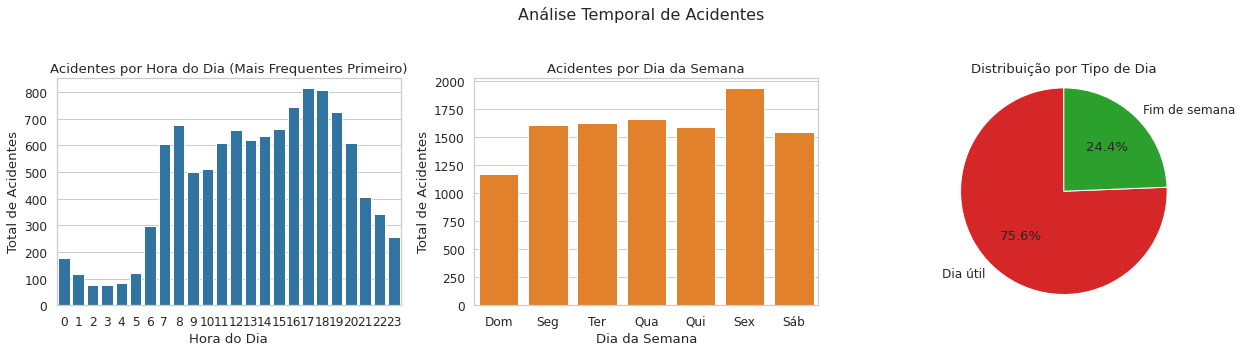

In [0]:
# Estilo visual
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

# Dados SQL
df_temporal = spark.sql("""
  SELECT 
    hour(data_hora_boletim) as hora,
    dayofweek(data_hora_boletim) as dia_semana,
    CASE WHEN dayofweek(data_hora_boletim) IN (1,7) THEN 'Fim de semana' ELSE 'Dia útil' END as tipo_dia,
    COUNT(*) as total
  FROM acidentes_2021
  GROUP BY hora, dia_semana, tipo_dia
""").toPandas()

# Figura
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Acidentes por hora (ordenado por total)
hora_plot = df_temporal.groupby('hora')['total'].sum().sort_values(ascending=False)
sns.barplot(x=hora_plot.index, y=hora_plot.values, ax=axes[0], color='#1f77b4')
axes[0].set_title('Acidentes por Hora do Dia (Mais Frequentes Primeiro)')
axes[0].set_xlabel('Hora do Dia')
axes[0].set_ylabel('Total de Acidentes')

# Gráfico 2: Acidentes por dia da semana
dias = ['Dom', 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb']
dia_plot = df_temporal.groupby('dia_semana')['total'].sum().reindex(range(1, 8))
dia_plot.index = dias
sns.barplot(x=dia_plot.index, y=dia_plot.values, ax=axes[1], color='#ff7f0e')
axes[1].set_title('Acidentes por Dia da Semana')
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Total de Acidentes')

# Gráfico 3: Fim de semana vs Dia útil
tipo_plot = df_temporal.groupby('tipo_dia')['total'].sum()
axes[2].pie(tipo_plot, labels=tipo_plot.index, autopct='%1.1f%%', startangle=90, colors=['#d62728', '#2ca02c'])
axes[2].set_title('Distribuição por Tipo de Dia')
axes[2].axis('equal')  # círculo perfeito

plt.suptitle('Análise Temporal de Acidentes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [percentual] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


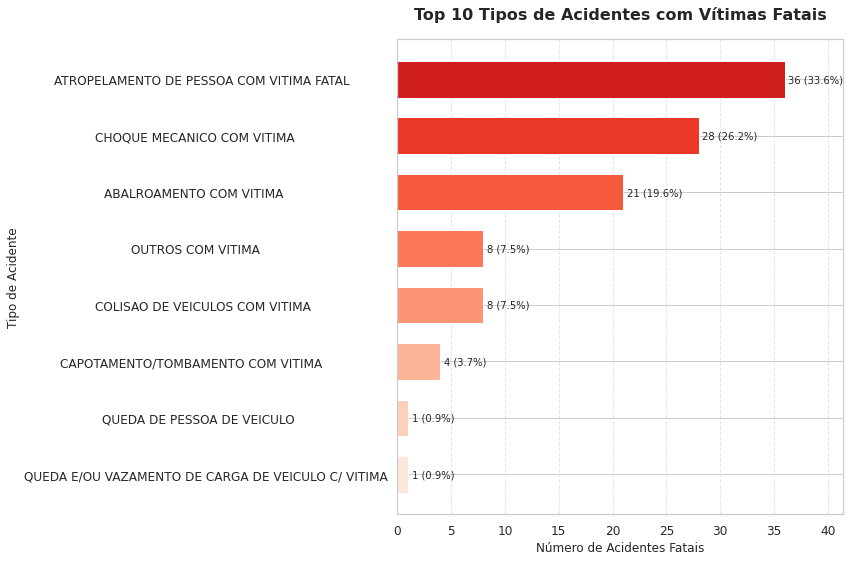

In [0]:
# Obter dados
df_tipos_fatais = spark.sql("""
  SELECT 
    descricao_tipo_acidente,
    COUNT(*) as total_fatais,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentual
  FROM acidentes_2021
  WHERE fatal = 1
  GROUP BY descricao_tipo_acidente
  ORDER BY total_fatais DESC
  LIMIT 10
""").toPandas()

# Ordenar uma vez para reuso
df_plot = df_tipos_fatais.sort_values('total_fatais')

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(df_plot['descricao_tipo_acidente'], df_plot['total_fatais'], 
               color=sns.color_palette("Reds", n_colors=10), height=0.65)

# Título e labels
ax.set_title('Top 10 Tipos de Acidentes com Vítimas Fatais', fontsize=16, pad=20, weight='bold')
ax.set_xlabel('Número de Acidentes Fatais', fontsize=12)
ax.set_ylabel('Tipo de Acidente', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Ajuste automático do limite do eixo x com folga
ax.set_xlim([0, df_plot['total_fatais'].max() * 1.15])

# Adicionar texto nas barras
for bar, percent in zip(bars, df_plot['percentual']):
    width = bar.get_width()
    ax.text(width + df_plot['total_fatais'].max() * 0.01, 
            bar.get_y() + bar.get_height()/2,
            f'{int(width)} ({percent:.1f}%)',
            va='center', fontsize=10)

plt.tight_layout()
plt.show()


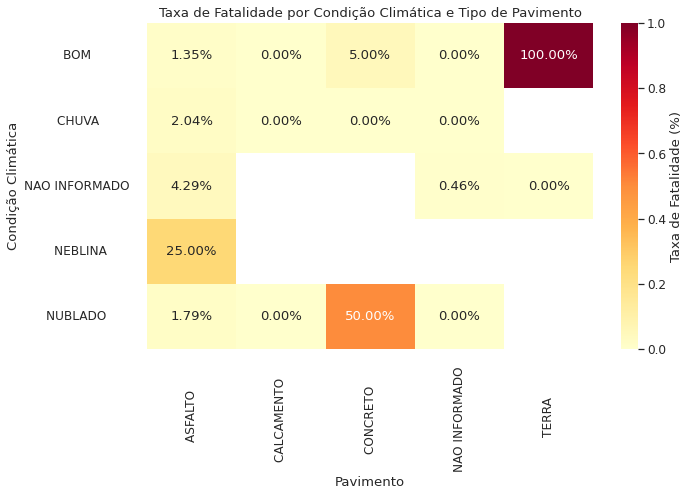

In [0]:
# Preparar dados
df_fatores = spark.sql("""
  SELECT 
    descricao_tempo,
    pavimento,
    AVG(fatal) as taxa_fatalidade
  FROM acidentes_2021
  GROUP BY descricao_tempo, pavimento
""").toPandas()

# Pivot para heatmap
heatmap_data = df_fatores.pivot(index="descricao_tempo", columns="pavimento", values="taxa_fatalidade")

# Ordenar índices (opcional, se fizer sentido no seu caso)
heatmap_data = heatmap_data.sort_index()

# Gráfico
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Taxa de Fatalidade (%)'})
plt.title('Taxa de Fatalidade por Condição Climática e Tipo de Pavimento')
plt.xlabel('Pavimento')
plt.ylabel('Condição Climática')
plt.show()

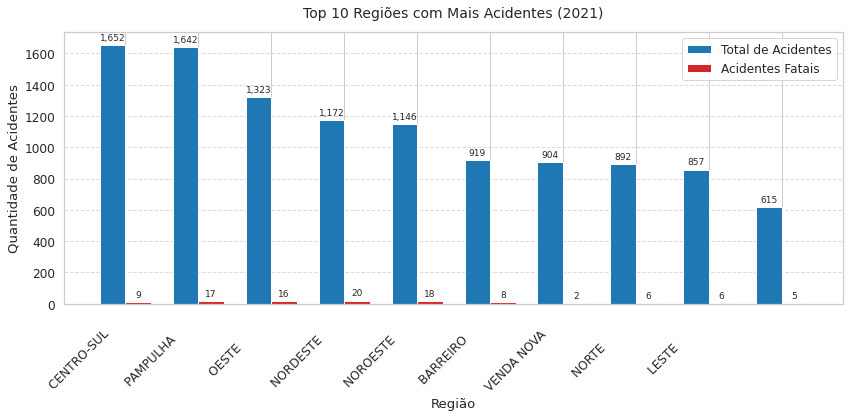

In [0]:
# Consulta com Spark SQL
df_regioes = spark.sql("""
  SELECT 
    descricao_regional as regiao,
    COUNT(*) as total_acidentes,
    SUM(CASE WHEN fatal = 1 THEN 1 ELSE 0 END) as fatais
  FROM acidentes_2021
  GROUP BY regiao
  ORDER BY total_acidentes DESC
  LIMIT 10
""").toPandas()

# Dados para o gráfico
regioes = df_regioes['regiao']
totais = df_regioes['total_acidentes']
fatais = df_regioes['fatais']

# Posições das barras
x = np.arange(len(regioes))
largura = 0.35

# Criar gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Barras lado a lado
b1 = ax.bar(x - largura/2, totais, width=largura, color='#1f77b4', label='Total de Acidentes')
b2 = ax.bar(x + largura/2, fatais, width=largura, color='#d62728', label='Acidentes Fatais')

# Adicionar valores nas barras
for bar in b1 + b2:
    height = bar.get_height()
    ax.annotate(f'{height:,}',  # separador de milhar
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # deslocamento para cima
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=9)

# Customizações
ax.set_title('Top 10 Regiões com Mais Acidentes (2021)', fontsize=14, pad=15)
ax.set_xlabel('Região')
ax.set_ylabel('Quantidade de Acidentes')
ax.set_xticks(x)
ax.set_xticklabels(regioes, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

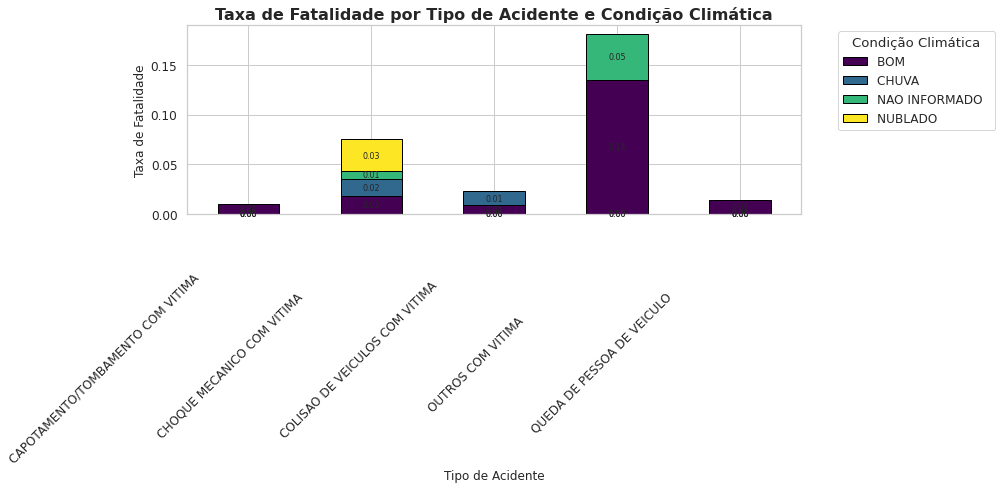

In [0]:
# Obter dados do Spark
df_combinacoes = spark.sql("""
  SELECT 
    descricao_tipo_acidente as tipo,
    descricao_tempo as clima,
    AVG(fatal) as taxa_fatalidade
  FROM acidentes_2021
  GROUP BY tipo, clima
  HAVING COUNT(*) > 30
  ORDER BY taxa_fatalidade DESC
  LIMIT 10
""").toPandas()

# Converter taxa_fatalidade para numérico
df_combinacoes['taxa_fatalidade'] = pd.to_numeric(df_combinacoes['taxa_fatalidade'])

# Pivotear os dados
df_pivot = df_combinacoes.pivot(
    index='tipo',
    columns='clima',
    values='taxa_fatalidade'
).fillna(0)

# Verificar se há dados
if not df_pivot.empty:
    # Definir cores com seaborn
    colors = sns.color_palette("viridis", n_colors=len(df_pivot.columns))

    # Criar figura
    ax = df_pivot.plot(
        kind='bar',
        stacked=True,
        figsize=(14, 7),
        colormap='viridis',
        edgecolor='black'
    )

    # Títulos e rótulos
    ax.set_title('Taxa de Fatalidade por Tipo de Acidente e Condição Climática', fontsize=16, fontweight='bold')
    ax.set_xlabel('Tipo de Acidente', fontsize=12)
    ax.set_ylabel('Taxa de Fatalidade', fontsize=12)

    # Rotacionar os rótulos do eixo x
    plt.xticks(rotation=45, ha='right')

    # Legenda
    ax.legend(title='Condição Climática', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adicionar valores nas barras (opcional)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("Não há dados suficientes para gerar o gráfico")


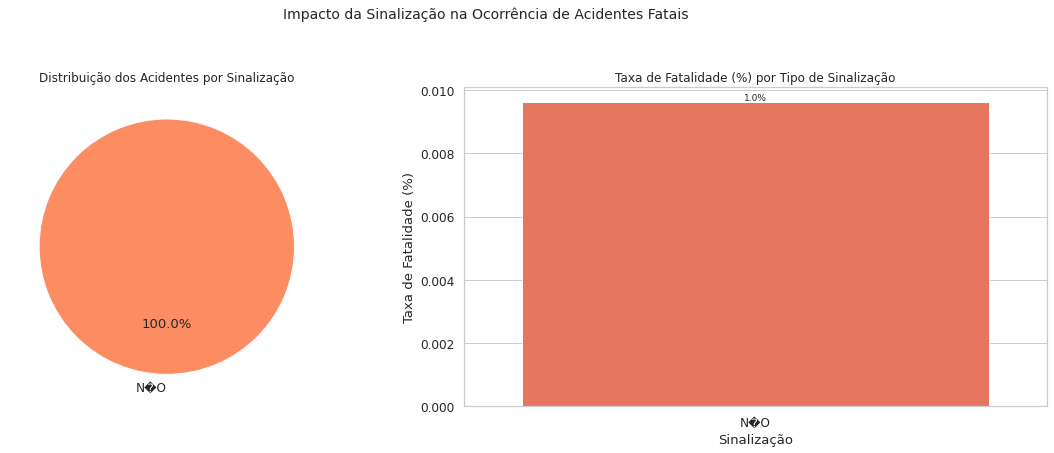

In [0]:
# Dados de sinalização
sinal_df = spark.sql("""
  SELECT 
    local_sinalizado,
    COUNT(*) as total,
    AVG(fatal) as taxa
  FROM acidentes_2021
  GROUP BY local_sinalizado
""").toPandas()

# Ordenar para consistência visual
sinal_df = sinal_df.sort_values('total', ascending=False)

# Cores customizadas
cores_pizza = ['#fc8d62', '#66c2a5']
cores_barras = ['#2ca02c', '#d62728'] if len(sinal_df) == 2 else sns.color_palette('Reds', len(sinal_df))

# Criar subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Gráfico de pizza
ax1.pie(
    sinal_df['total'], 
    labels=sinal_df['local_sinalizado'], 
    autopct=lambda p: f'{p:.1f}%' if p > 3 else '',  # evita poluir o gráfico com % pequenas
    startangle=90, 
    colors=cores_pizza,
    wedgeprops={'edgecolor': 'white'}
)
ax1.set_title('Distribuição dos Acidentes por Sinalização', fontsize=12)

# Gráfico de barras
sns.barplot(
    x='local_sinalizado', 
    y='taxa', 
    data=sinal_df, 
    palette=cores_barras, 
    ax=ax2
)
ax2.set_title('Taxa de Fatalidade (%) por Tipo de Sinalização', fontsize=12)
ax2.set_ylabel('Taxa de Fatalidade (%)')
ax2.set_xlabel('Sinalização')

# Mostrar valores nas barras
for container in ax2.containers:
    ax2.bar_label(container, labels=[f'{v:.1%}' for v in sinal_df['taxa']], fontsize=9, label_type='edge')

# Título geral
plt.suptitle('Impacto da Sinalização na Ocorrência de Acidentes Fatais', fontsize=14, y=1.05)

plt.tight_layout()
plt.show()